In [1]:
import albumentations as A
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
DATA_ROOT = '/opt/ml/data/segmentation'
IMG_LOCATE = os.path.join(DATA_ROOT, 'train_1/images')
GT_LOCATE = os.path.join(DATA_ROOT, 'train_1/gt')
img_list = [i.split('.')[0] for i in os.listdir(os.path.join(DATA_ROOT, 'train_1/images'))]
print(len(img_list))
i = 0

2982


16.47309027777778


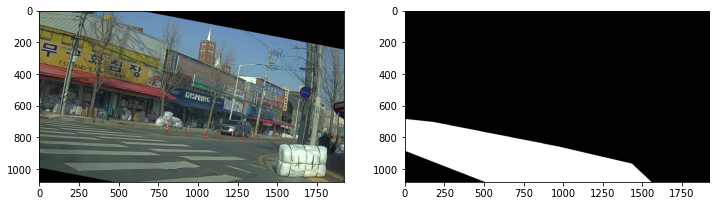

In [129]:
image = cv2.imread(os.path.join(IMG_LOCATE, img_list[i]+'.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

anno = cv2.imread(os.path.join(GT_LOCATE, img_list[i]+'.png'))

transform = A.Affine(p=1)(image=image, mask=anno)

fix, ax= plt.subplots(ncols=2, nrows=1, figsize=(12,9))
ax[0].imshow(transform['image'])
ax[1].imshow(np.where(transform['mask']==1, 255, transform['mask']))
#20percent 이상인 애들만
print(len(np.where(transform['mask']==1)[0])/(1920*1080*3)*100)
plt.show()

uint8
(1080, 1920, 3)


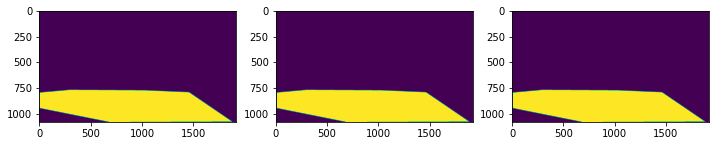

In [47]:
print(anno.dtype)
print(anno.shape)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,9))
ax[0].imshow(anno[:,:,:1])
ax[1].imshow(anno[:,:,1:2])
ax[2].imshow(anno[:,:,2:3])

plt.show()

In [92]:
contours, hierachy = cv2.findContours(image=anno[:,:,:1], mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

dummy = np.zeros_like(anno)
# cv2.drawContours(dummy, contours, -1, (255,0,0),10)

# print(sum(anno==dummy))

# plt.imshow(dummy)

# Image_patch

In [69]:
DATA_ROOT = '/opt/ml/data/segmentation'
IMG_LOCATE = os.path.join(DATA_ROOT, 'train_1/images')
GT_LOCATE = os.path.join(DATA_ROOT, 'train_1/gt')
img_list = [i.split('.')[0] for i in os.listdir(os.path.join(DATA_ROOT, 'train_1/images'))]
print(len(img_list))
i = 0
print(img_list[0])

2982
15887524


file_name : 15127726
1
shape : (1080, 1920)
box coord : 
[[   0    0]
 [1397    0]
 [   0 1080]
 [1397 1080]]
ratio of crosswalk in images : 0.36455439814814816
1080 864
0 1082


ValueError: empty range for randrange() (1080,864, -216)

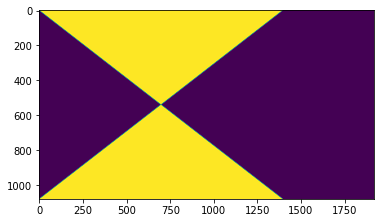

In [118]:
#MP_SEL_SUR_000033.jpg 2개
#MP_SEL_SUR_000110.jpg 5개
import random
NIMG_ROOT = '/opt/ml/data/segmentation/train_1/'
file_name = 'MP_SEL_SUR_008462' # 모래시계 그려짐
idx = random.randrange(0, 2982)
target_img = cv2.imread(os.path.join(NIMG_ROOT, f'images/{file_name}.jpg'))
target_gt = cv2.imread(os.path.join(NIMG_ROOT, f'gt/{file_name}.png'))

print(f"file_name : {img_list[idx]}")
target_gt = target_gt[:,:,0]
contours, hierachy = cv2.findContours(image=target_gt[:,:], mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

# dummy = np.zeros_like(target_gt)
# cv2.drawContours(dummy, contours, -1, (255,0,0),10)

#plt.imshow(dummy)
# fig,ax = plt.subplots(ncols=3, nrows=1, figsize=(12,9))
# ax[0].imshow(target_img)
# ax[1].imshow(target_gt)
# ax[2].imshow(dummy)
# plt.show()
# 50% 이상은 탈락
# 20% - 30% : 1450 장
# contour 가 1개인 경우에만 paste 적용
# 1. contour 를 포함하는 최소 박스를 그린다
# 2. 그 박스를 잘라내서 일정 비율로 감소
# 3. 어딘가(.....?)에 붙이는 작업을 진행한드아
#  3.1 좌표를 활용하여 가로, 세로, 무게중심을 구한다.
#  3.2 가로가 긴 경우, 위 아래의 여유를 확인 
#  3.3 세로가 긴 경우, 좌 우의 여유를 확인
print(len(contours))

image, anno = target_img, target_gt
x,y,w,h = cv2.boundingRect(contours[0])
# x,y,w,h
# dummy = cv2.drawContours(dummy,[box], 0, (0,255,0), 10)
dummy = np.zeros_like(anno)
box = np.array([[x,y], [x+w,y], [x,y+h], [x+w ,y+h]])
dummy = cv2.fillPoly(dummy , [box], 255)
d_shape = dummy.shape
#fillpoly 로 한 차원에만 255로 값을 채워주기 때문에 dim 까지 곱할 핑료가 없다.
print(f'shape : {d_shape}\nbox coord : \n{box}')
print(f'ratio of crosswalk in images : {len(np.where(dummy==255)[0])/(d_shape[0] * d_shape[1])}')

# plt.imshow(dummy)
# print(f'width: {} , height: {}')

ratio = w / h

WIDTH = dummy.shape[1]
HEIGHT = dummy.shape[0]

# Contour 영역을 축소해서 붙여넣는다.
img_patch = image[y:y+h, x:x+w]
ann_patch = anno[y:y+h, x:x+w]

# img_patch = cv2.resize(img_patch, (0,0), fx=0.5, fy=0.5) 

x_start = 20
y_start = 50

import random

# 가로가 더 긴 경우
if ratio > 1:

    w_c = int(round(0.6 * w, 0))
    h_c = int(round(0.2 * h, 0))

    img_patch = cv2.resize(img_patch, dsize=(w_c, h_c))
    ann_patch = cv2.resize(ann_patch, dsize=(w_c, h_c))

    if (y+h+y) / 2 > HEIGHT / 2:
        # 활용 가능한 Box 영역 : (0,0) ~ (WIDTH,y)
        # 위쪽 영역 남음
        print(0, y-h_c)
        print(0, WIDTH-w_c)
        y_start, x_start = random.randrange(0, y-h_c), random.randrange(0, WIDTH-w_c)
        print("type 1")
        pass
    else:
        # 활용 가능한 Box 영역 : (0,y+h) ~ (WIDTH-w, HEIGHT-h)
        # 아래쪽 영역 남음
        print(y+h, HEIGHT-h_c)
        print(0, WIDTH-w_c)
        y_start, x_start = random.randrange(y+h, HEIGHT-h_c), random.randrange(0, WIDTH-w_c)
        print("type 2")        
        pass

    image[y_start:y_start+h_c, x_start:x_start+w_c] = img_patch
    anno[y_start:y_start+h_c, x_start:x_start+w_c] = ann_patch

# 세로가 더 긴 경우
else:
    w_c = int(round(0.2 * (WIDTH - w), 0))
    h_c = int(round(0.6 * h, 0))

    img_patch = cv2.resize(img_patch, dsize=(w_c, h_c))
    ann_patch = cv2.resize(ann_patch, dsize=(w_c, h_c))

    if (x+w+x) > WIDTH:
        # 활용 가능한 Box 영역 : (0,0) ~ (x,HEIGHT)
        # 왼쪽 영역이 남음
        print(0, HEIGHT-h_c, 0, x-w_c)
        y_start, x_start = random.randrange(0, HEIGHT-h_c), random.randrange(0, x-w_c)
        print("type 3")
        pass
    else:
        # 활용 가능한 Box 영역 : (x+w,0) ~ (WIDTH, HEIGHT)
        # 오른쪽 영역이 남음
        print(0, HEIGHT-h_c, x+w, WIDTH-w_c)
        y_start, x_start = random.randrange(0, HEIGHT-h_c), random.randrange(x+w, WIDTH-w_c)
        print("type 4")
        pass

    image[y_start:y_start+h_c, x_start:x_start+w_c] = img_patch
    anno[y_start:y_start+h_c, x_start:x_start+w_c] = ann_patch



#rect_center_point = [w/2, h/2]
#img_center_point = [d_shape[1]/2, d_shape[0]/2]
#print(rect_center_point, img_center_point)
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12,7))
ax[0].imshow(image)
ax[1].imshow(anno)
ax[2].imshow(dummy)
# cv2.rectangle()


# 앙 실패띠